# SARDI Capture Evaluation

First a qualitative comparison of rgb image, averaged 'ground truth', the original image, and the classified result.

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import cv2
import os

from spectral import *

from os.path import exists

from sklearn.decomposition import PCA

from skimage.segmentation import slic, mark_boundaries

from sklearn.cluster import KMeans

In [7]:
path = "processed-data/sardi-capture-final/final/reflectance/2023_03_28/just_waste/"

data_set = 'sardi-final'

dir_cont = os.listdir(path)

data_cubes = [cont for cont in dir_cont if '.nc' in cont]

data_cubes = sorted(data_cubes)

cubes = data_cubes

print(cubes)

['2023_03_28-01_45_56.nc', '2023_03_28-01_48_52.nc', '2023_03_28-01_51_30.nc', '2023_03_28-01_54_05.nc', '2023_03_28-01_56_37.nc', '2023_03_28-01_58_54.nc']


In [8]:
iteration='2023_03_28-01_54_05'

## Loading Data

Here I'm going to use my pre-processed files containing reflectance values.

Given the fact that OpenHSI saves them in NetCDF format I'm using the `netCDF4` library to load them.

I'm also transposing the data array into a more comment layout.

In [9]:
fn = path + iteration + ".nc"
fn_rad = fn.replace('reflectance','radiance')

In [10]:
# Load data
ds = nc.Dataset(fn)
ds_rad = nc.Dataset(fn_rad)

In [11]:
# extract the datacube from the dataset
dc = np.array(ds['datacube'])

In [12]:
# Data needs to be x, y, bands instead of bands, x, y.
data = dc.transpose(1,2,0)

In [13]:
# limit data to area of interest?
# data = data[:430,:930, :]

In [14]:
# transform into a line of pixels for PCA
X = data.copy().reshape(data.shape[0]*data.shape[1],data.shape[2])

In [15]:
print(X.shape)

(395100, 131)


## Useful Functions

In [16]:
def process_into_rgb(loc_ds):
    """
    Processes a given dataset into an rgb image for display
    """
    loc_dc = np.array(loc_ds['datacube'])
    data = loc_dc.transpose(1,2,0)
    # data = data[:430,:930, :] # limit to area we are interested in
    loc_binned_wavelengths = np.array(loc_ds['wavelength'])
    loc_image = np.zeros((data.shape[0],data.shape[1],3), np.uint8)
    
    # This is not working, it could be a ram issue
    # input_tens = torch.tensor(data, dtype=torch.float32, device="cpu")
    # hyres = hyde.HyRes()
    # dn_data = hyres(input_tens).numpy()
    dn_data = data

    loc_red_wavelength = 620
    loc_green_wavelength = 560
    loc_blue_wavelength = 460

    loc_red_layer = dn_data[:,:,np.argmin(np.abs(loc_binned_wavelengths-loc_red_wavelength))]  
    loc_green_layer = dn_data[:,:,np.argmin(np.abs(loc_binned_wavelengths-loc_green_wavelength))] 
    loc_blue_layer = dn_data[:,:,np.argmin(np.abs(loc_binned_wavelengths-loc_blue_wavelength))]
    
    loc_image[:,:,0] = loc_red_layer
    loc_image[:,:,1] = loc_green_layer
    loc_image[:,:,2] = loc_blue_layer

    # scale the values to within the central 2 to 98 percent values to remove outlier readings
    loc_vmax = np.nanpercentile(loc_image, 98)
    loc_vmin = np.nanpercentile(loc_image, 2)
    loc_image = ((loc_image.astype("f8") - loc_vmin) / (loc_vmax - loc_vmin)).astype("f4")
    loc_image = np.minimum(np.maximum(loc_image, 0), 1)

    loc_image *= 255
    loc_image = loc_image.astype(np.uint8)
    
    return loc_image

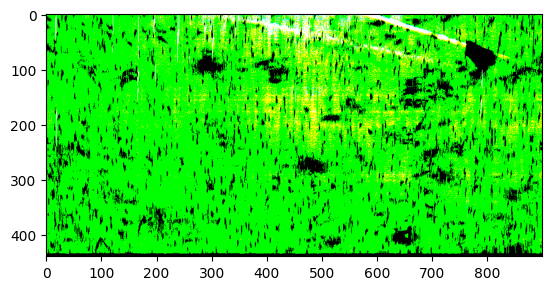

In [17]:
plt.imshow(process_into_rgb(ds_rad))

## Reducing Dimentionality

I'm just going to perform a simple PCA here to reduce the dimentionality of the image. I should be able to reduce the number of bands without distorting the spacial data and then apply the segmentation later to the original data, or an RGB representation, if I wish.

The first section of code is redundant and only there for sanity checking and illustrative purposes

### PCA

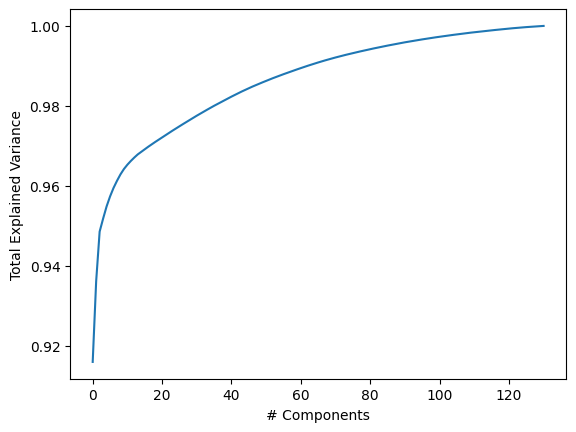

In [18]:
run = True
if run:
    pca = PCA()

    # fit my data, and transform
    pcX = pca.fit_transform(X)

    # graph the variance of each component (should give a good idea about the number of components to use).
    ev = pca.explained_variance_ratio_
    cumulativeVar = np.cumsum(ev)
    
    plt.plot(cumulativeVar)
    plt.xlabel('# Components')
    plt.ylabel('Total Explained Variance')
    plt.savefig('evaluations/'+data_set+'/'+iteration+'_pca_elbow.png')
    plt.show()

Now to actually perform the PCA.

In [19]:
# pick number of components that seems reasonable.
nComp = 10 # between 85-90% of the variance
pca = PCA(n_components=nComp)
pca.fit(X)
pcX = pca.transform(X)

In [20]:
# check the new dimensions
print(pcX.shape)

(395100, 10)


In [21]:
# reformat the image into the original shape
image_pca = pcX.reshape(data.shape[0], data.shape[1], pcX.shape[1])
print(image_pca.shape)

(439, 900, 10)


In [22]:
# let's have a look at the reduced image, if using 3 components
if image_pca.shape[2] == 3:
    plt.imshow(image_pca, 'gray')

## K-means elbow method to determine optimal n_clusters

/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in

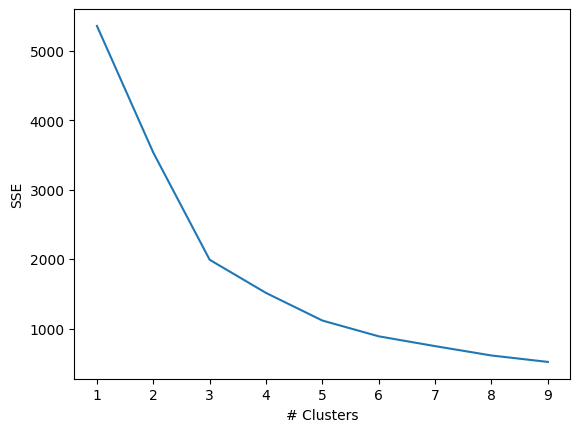

In [23]:
# Only running this once to prove a point, it takes too long.
run = True
if run:
    inertia = {}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k).fit(pcX)
        inertia[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(inertia.keys()), list(inertia.values()))
    plt.xlabel("# Clusters")
    plt.ylabel("SSE")
    plt.savefig('evaluations/'+data_set+'/'+iteration+'_k-means_elbow.png')
    plt.show()

## Classification

In [28]:
# create our classifier
k_means = KMeans(n_clusters=6) # based on elbow method above, going to stick to this number

In [29]:
# classify
k_fit = k_means.fit(pcX)

/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [30]:
# capture clusers and labels
x_labels = k_means.labels_
x_cluster = x_labels.reshape(image_pca[:, :, 0].shape)

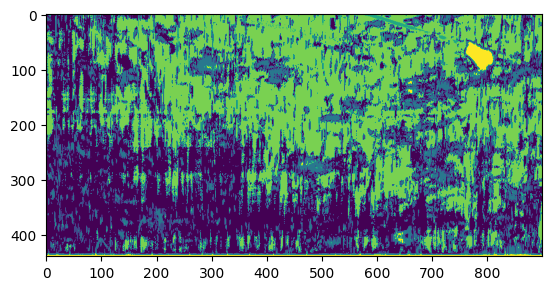

In [31]:
plt.imshow(x_cluster)
plt.imsave('evaluations/'+data_set+'/'+iteration+'_classification.png', x_cluster)

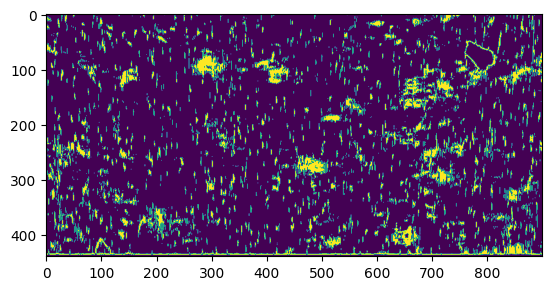

In [33]:
def change_value(img, v_from, v_to):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == v_from:
                img[i,j] = v_to
    return img

classified_waste = x_cluster.copy()
                
classified_waste = change_value(classified_waste, 0, 0)
classified_waste = change_value(classified_waste, 1, 0)
classified_waste = change_value(classified_waste, 2, 1)
classified_waste = change_value(classified_waste, 3, 0)
classified_waste = change_value(classified_waste, 4, 0)
classified_waste = change_value(classified_waste, 5, 0)
# classified_waste = change_value(classified_waste, 6, 0)
# classified_waste = change_value(classified_waste, 7, 0)
            
plt.imshow(classified_waste)

In [34]:
plt.imsave('evaluations/'+data_set+'/'+iteration+'_class_waste.png', classified_waste)

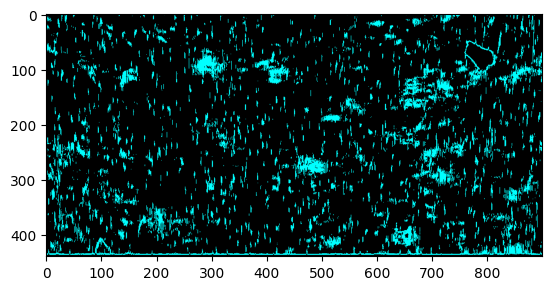

In [35]:
final = [np.full(x_cluster.shape,0),classified_waste,classified_waste]
final = np.array(final).transpose(1,2,0)*255
final = final.astype(np.uint8)
plt.imshow(final)
plt.imsave('evaluations/'+data_set+'/'+iteration+'_class_final.png', final)

## Blend original and classification

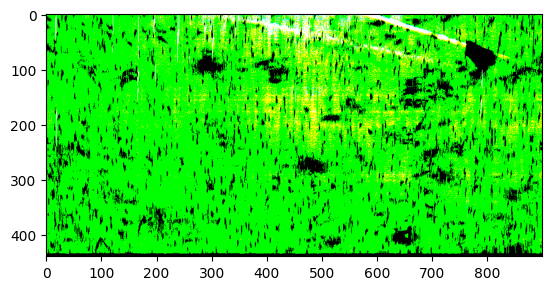

In [36]:
original = process_into_rgb(ds_rad)
plt.imshow(original)
plt.imsave('evaluations/'+data_set+'/'+iteration+'_original.png', original)

In [37]:
print(original.shape)
print(original.dtype)
print(final.shape)
print(final.dtype)

(439, 900, 3)
uint8
(439, 900, 3)
uint8


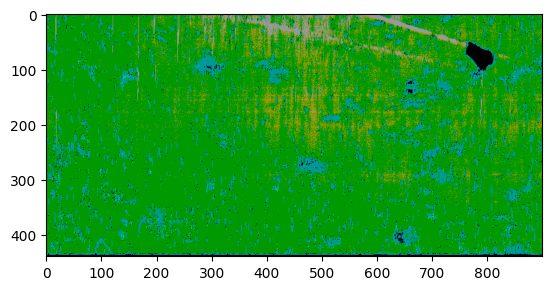

In [38]:
blended = cv2.addWeighted(final, 0.6, original, 0.6, 0)
plt.imshow(blended)
plt.imsave('evaluations/'+data_set+'/'+iteration+'_blended.png', blended)